In [53]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# import tensorflow as tf
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [54]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from matplotlib import cm
import ast
import math
import pandas as pd
import os
from IPython.display import display, Latex

In [55]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [56]:
# tf.random.set_seed(42)
# np.random.seed(42)

In [57]:
tf.keras.backend.set_floatx("float64")

In [58]:
def record_and_update_performance(value, filename):
    existing_times = []
    try:
        with open(filename, 'r') as file:
            for line in file:
                line = line.strip()
                if line.startswith('[') and line.endswith(']'):
                    try:
                        numbers = ast.literal_eval(line)
                        if isinstance(numbers, list):
                            existing_times.extend(numbers)
                    except (SyntaxError, ValueError):
                        print(f"Skipping invalid list format: {line}")
                elif line.replace('.', '', 1).isdigit():
                    try:
                        existing_times.append(float(line))
                    except ValueError:
                        print(f"Skipping invalid float format: {line}")
                else:
                    print(f"Skipping non-numeric line: {line}")
    except FileNotFoundError:
        print("No existing file found. A new file will be created.")

    existing_times.append(value)
    
    avg = np.mean(existing_times)
    min_val = np.min(existing_times)
    max_val = np.max(existing_times)
    
    deviation_min = avg - min_val
    deviation_max = max_val - avg
    
    with open(filename, 'w') as file:
        for time_record in existing_times:
            file.write(f"{time_record}\n")
        minutes_avg = int(avg // 60)
        seconds_avg = int(avg % 60)
        text = f"Average among {len(existing_times)} trainings: {minutes_avg:.2f}min {seconds_avg}s, (Deviation from Min: {deviation_min:.2f}s, Deviation from Max: {deviation_max:.2f}s), STD: {np.std(existing_times)}\n"
        file.write(text)
        print(text)
    
    print("Updated data recorded successfully.")

In [59]:
class Heat1DPINN():
    def __init__(self, input_shape=1, out_shape=1, layers=[10, 10, 10], activation='tanh', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04)):
        super(Heat1DPINN, self).__init__()
        self.optimizer = optimizer
        self.model = self.build(input_shape, out_shape, layers, activation)

    def build(self, input_shape, output_shape, layers, activation):
        input_layer = tf.keras.layers.Input(shape=(input_shape,))
        kernel_initializer=tf.keras.initializers.GlorotNormal() # seed=177013

        hidden = [tf.keras.layers.Dense(layers[0], activation=activation)(input_layer)]
        for i in range(1, len(layers)):
            new_layer = tf.keras.layers.Dense(
                    layers[i],
                    activation=activation,
                    activity_regularizer=None,
                    kernel_initializer=kernel_initializer
                )(hidden[-1])
            hidden.append(new_layer)

        output_layer = tf.keras.layers.Dense(output_shape, activation=None)(hidden[-1])

        name = f"DNN-{len(layers)}"
        model = tf.keras.Model(input_layer, output_layer, name=name)
        model.summary()
    
        return model

    @tf.function
    def dirichlet_condition(self, x_bc, y_bc, u_bc):
        x_t = tf.concat([x_bc, y_bc], axis=1)
        u = self.model(x_t)
        return 10 * tf.reduce_mean(tf.square(u - u_bc))

    @tf.function
    def loss_fn(self, x_in, y_in, x_bc, y_bc, u_bc):
        x_y = tf.concat([x_in, y_in], axis=1)
        u0 = self.model(x_y)
        u_x = tf.gradients(u0, x_in)[0]
        u_y = tf.gradients(u0, y_in)[0]
        u_xx = tf.gradients(u_x, x_in)[0]
        u_yy = tf.gradients(u_y, y_in)[0]
        heat_eq = u_xx + u_yy
        bc_dirichlet = self.dirichlet_condition(x_bc, y_bc, u_bc)

        return 0.7 * tf.reduce_mean(tf.square(heat_eq)) + 5 * bc_dirichlet

    def save_model(self, epoch, base_path='model_2d_heat_ring_checkpoints'):
        if not os.path.exists(base_path):
            os.makedirs(base_path)
        model_path = os.path.join(base_path, f'model_2d_heat_ring_at_epoch_{epoch}.h5')
        self.model.save(model_path)
        print(f"Model saved at {model_path}")
    
    def train(self, loss_threshold, x_in, y_in, x_bc, y_bc, u_bc):
        loss_array = []
        start_time = time.time()
        best_epoch_times = math.inf
        loss = tf.constant(float('inf'))
        epoch = 0
        try:
            while loss.numpy() > loss_threshold:
                with tf.GradientTape() as tape:
                    loss = self.loss_fn(x_in, y_in, x_bc, y_bc, u_bc)
                grads = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

                elapsed_time = time.time() - start_time
                if (best_epoch_times > elapsed_time):
                    best_epoch_times = elapsed_time
                minutes = int(elapsed_time // 60)
                seconds = int(elapsed_time % 60)
                loss_array.append(loss)
                if epoch % 100 == 0:
                    print(f'Epoch {epoch}, Loss: {loss.numpy()}, Min loss: {min(loss_array)}, time: {"%d minutes and %d seconds" % (minutes, seconds)}')
                if epoch % 100 == 0:
                    self.save_model(epoch)
                epoch += 1
        except KeyboardInterrupt:
            print("Training stopped manually")

        elapsed_time = time.time() - start_time
        minutes = int(elapsed_time // 60)
        seconds = int(elapsed_time % 60)
        print("Training took %d minutes and %d seconds" % (minutes, seconds))
        print(f"Last epoch: {epoch}, loss: {loss.numpy()}, time: {elapsed_time}")
        print(f"Best epoch: {np.argmin(loss_array)}, loss: {min(loss_array)}, time: {best_epoch_times}")
        record_and_update_performance(elapsed_time, 'performance_data_ring.txt')

        plt.figure()
        plt.plot(loss_array)
        plt.xlabel('Епоха')
        plt.ylabel('Втрати')
        plt.grid()
        plt.title('Значення втрат')
        plt.savefig("1d_nonstationary_heat_equation_training.png")
        plt.show(block=False)

        start_epoch = 1000
        end_epoch = 3000

        end_epoch = min(end_epoch, len(loss_array) - 1)

        plt.plot(range(start_epoch, end_epoch + 1), loss_array[start_epoch:end_epoch + 1])
        plt.xlabel('Епоха')
        plt.ylabel('Втрати')
        plt.grid()
        plt.title('Значення втрат від 1000 до 3000 епохи')
        plt.show(block=False)

In [60]:
N_of_train_points_2D = 100
N_of_test_points_2D = 500
N_of_fem_points_2D = 10
N_of_time_steps = 100
L_x = 0.0
R_x = 1.0
L_t = 0.0
R_t = 0.2
Dirichlet_up_2D = 0.0
Dirichlet_down_2D = 0.0
loss_threshold_2D = 0.001
Layers_2D = [30, 30, 30]
Learning_rate_2D = 5e-4
Optimizer_2D = tf.keras.optimizers.Adam(learning_rate=Learning_rate_2D)


model_2D = Heat1DPINN(2, 1, Layers_2D, 'tanh', Optimizer_2D) # 'tanh'
# tf.keras.utils.plot_model(model_2D.model, to_file='model_plot.png', show_shapes=True, 
#                           show_layer_names=True, show_dtype=True, 
#                           show_layer_activations=True)

Model: "DNN-3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_8 (Dense)             (None, 30)                90        
                                                                 
 dense_9 (Dense)             (None, 30)                930       
                                                                 
 dense_10 (Dense)            (None, 30)                930       
                                                                 
 dense_11 (Dense)            (None, 1)                 31        
                                                                 
Total params: 1,981
Trainable params: 1,981
Non-trainable params: 0
_________________________________________________________________


/home/user/miniconda3/envs/fenicsproject/lib/python3.8/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [61]:

class CircularDomain:
    def __init__(self, r, R,
                 n_boundary_points, n_colloc_points,
                 bc1, bc2):
        if r >= R:
            r, R = R, r
        self.R, self.r = R, r
        self.n_bcp = n_boundary_points
        self.n_cp = int(n_colloc_points / np.pi / (R**2 - r**2) * 4*R**2)
        self.bc1_v, self.bc2_v = bc1, bc2
    
    def __circle(self, radius, n):
        m = n//2
        x = np.linspace(-radius, +radius, m, endpoint = True)
        y = np.sqrt(radius**2 - x**2)
        x = np.append(x, x[::-1])
        y = np.append(y, -y)
        return x, y

    def __isDoughnot(self, x, y, r_out, r_in = 0):
        return r_in**2 < x**2 + y**2 < r_out**2
    
    def makeDomain(self, doPlot=True):
        isDoughnot_vec = np.vectorize(self.__isDoughnot)
        if doPlot:
            plt.figure(figsize = (10, 10))
        for rad in [self.R, self.r]:
            x, y = self.__circle(rad, self.n_bcp)
            if doPlot:
                plt.plot(x, y, "k")
        points = (2 * (np.random.rand(self.n_cp, 2) - .5)) * self.R # random in [0., 1.)
        x, y = points[:, 0], points[:, 1]
        x, y = x[isDoughnot_vec(x, y, self.R, self.r)], y[isDoughnot_vec(x, y, self.R, self.r)]
        if doPlot:
            plt.plot(x, y, marker = ".", color = "r", markersize = 2, linestyle = "")
            plt.axis("square")
            plt.xlabel("$x_1$")
            plt.ylabel("$x_2$")
            plt.show()
        xbc, ybc = self.__circle(self.r, self.n_bcp)
        bc1 = np.zeros([self.n_bcp, 3])
        bc1[:, 0], bc1[:, 1], bc1[:, 2] = xbc, ybc, self.bc1_v(xbc, ybc)
        #
        xbc, ybc = self.__circle(self.R, self.n_bcp)
        bc2 = np.zeros([self.n_bcp, 3]) * 10
        bc2[:, 0], bc2[:, 1], bc2[:, 2] = xbc, ybc, self.bc2_v(xbc, ybc)
        self.bc1 = bc1
        self.bc2 = bc2
        #
        colloc = np.zeros([x.shape[0], 2])
        colloc[:, 0], colloc[:, 1] = x, y
        data = np.append(bc1, bc2, axis = 0)
        self.colloc, self.data = colloc, data

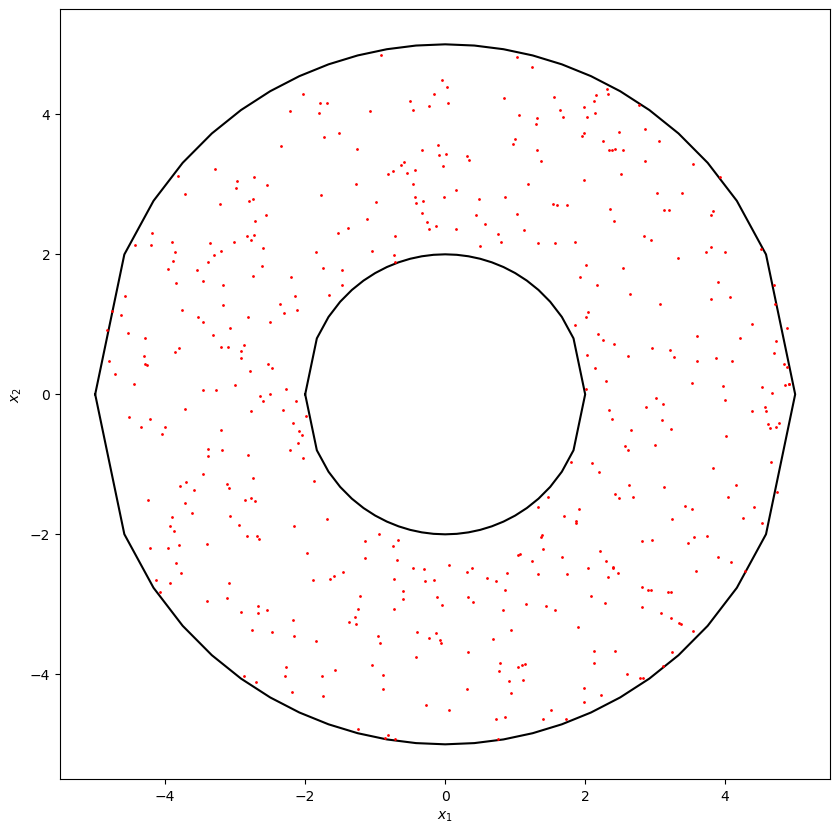

In [62]:
inner_radius = 2.0
outer_radius = 5.0
n_boundary_points = 50
n_colloc_points = 500
def bc1(x, y):
    return x
def bc2(x, y):
    return np.zeros_like(x)

c = CircularDomain(inner_radius, outer_radius, n_boundary_points, n_colloc_points, bc1, bc2)
c.makeDomain()

x_bc, y_bc, u_bc = map(lambda x: np.expand_dims(x, axis=1), 
                    [c.data[:, 0], c.data[:, 1], c.data[:, 2]])

x_in, y_in = map(lambda x: np.expand_dims(x, axis=1), 
               [c.colloc[:, 0], c.colloc[:, 1]])

x_in, y_in, x_bc, y_bc, u_bc = map(
    lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
    [x_in, y_in, x_bc, y_bc, u_bc]
)

2024-05-16 11:16:04.278445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_11' with dtype int32
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_11}}]]


Epoch 0, Loss: 41.55649176452235, Min loss: 41.55649176452235, time: 0 minutes and 2 seconds
Model saved at model_2d_heat_ring_checkpoints/model_2d_heat_ring_at_epoch_0.h5
Epoch 100, Loss: 10.951965028161302, Min loss: 10.951965028161302, time: 0 minutes and 3 seconds
Model saved at model_2d_heat_ring_checkpoints/model_2d_heat_ring_at_epoch_100.h5
Epoch 200, Loss: 0.9750805425291565, Min loss: 0.9750805425291565, time: 0 minutes and 4 seconds
Model saved at model_2d_heat_ring_checkpoints/model_2d_heat_ring_at_epoch_200.h5
Epoch 300, Loss: 0.17055779137501342, Min loss: 0.17055779137501342, time: 0 minutes and 6 seconds
Model saved at model_2d_heat_ring_checkpoints/model_2d_heat_ring_at_epoch_300.h5
Epoch 400, Loss: 0.11615076703308763, Min loss: 0.11615076703308763, time: 0 minutes and 7 seconds
Model saved at model_2d_heat_ring_checkpoints/model_2d_heat_ring_at_epoch_400.h5
Epoch 500, Loss: 0.10582130894430074, Min loss: 0.10582130894430074, time: 0 minutes and 8 seconds
Model saved a

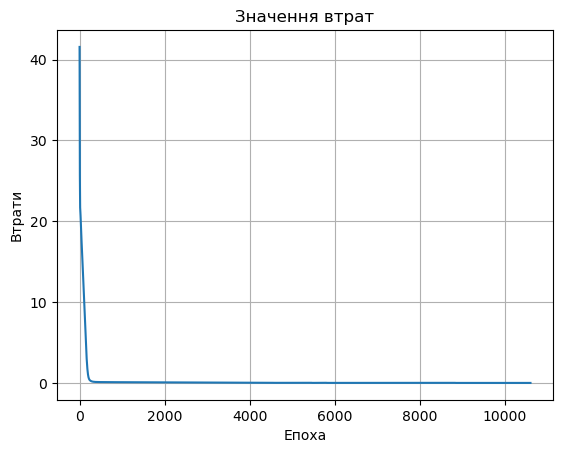

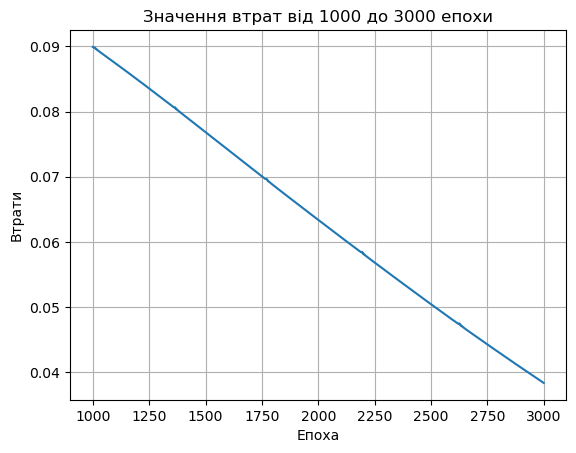

In [63]:
model_2D.train(loss_threshold_2D, x_in, y_in, x_bc, y_bc, u_bc)

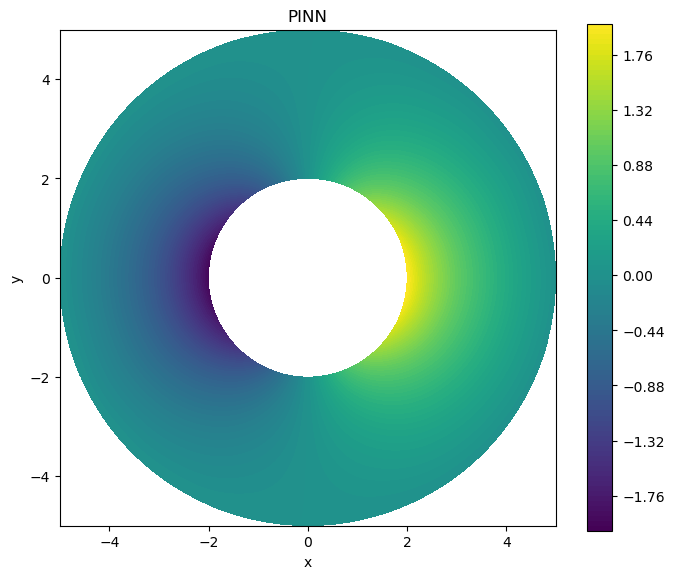

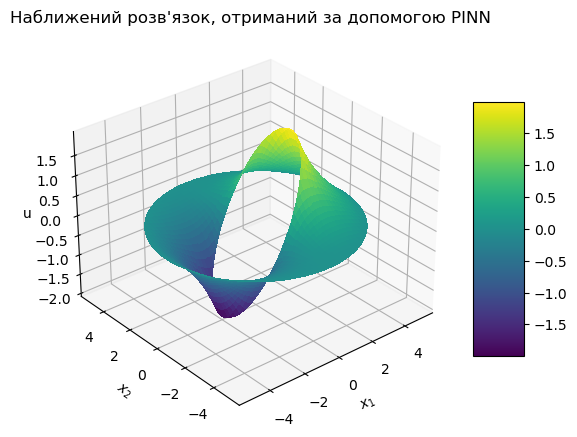

In [64]:
plt.figure("", figsize=(7, 6))

n = 1000
x, y = np.linspace(-c.R, +c.R, n), np.linspace(-c.R, +c.R, n)
X0, Y0 = np.meshgrid(x, y)
X = X0.reshape([n**2, 1])
Y = Y0.reshape([n**2, 1])
xt_test = np.column_stack([X.ravel(), Y.ravel()])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)
u_pinn = model_2D.model(xt_test)
u_pinn = u_pinn.numpy()
u_pinn[X**2 + Y**2 > c.R**2] = None
u_pinn[X**2 + Y**2 < c.r**2] = None

u_pinn = u_pinn.reshape(n, n)

plt.contourf(X0, Y0, u_pinn, cmap="viridis", levels = 100)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN")
plt.tight_layout()
plt.axis("square")
plt.show()

fig = plt.figure(figsize=(11, 6.6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X0, Y0, u_pinn, cmap='viridis', linewidth=0, antialiased=False, label='PINN Solution 2D', zorder=0)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('u', labelpad=0)
ax.set_title('Наближений розв\'язок, отриманий за допомогою PINN')
plt.subplots_adjust(left=0.45) 
color_for_legend = cm.viridis(0.5)
ax.view_init(elev=30, azim=-130)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()
     

Solving linear variational problem.
(197,)


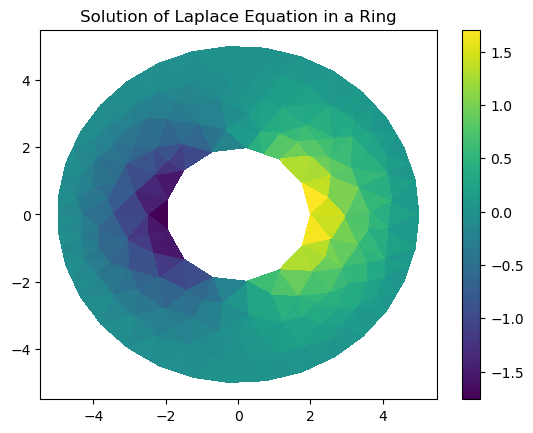

In [65]:
from fenics import *
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from mshr import *

def solve_with_fem(N_coarse):
    domain = Circle(Point(0, 0), outer_radius) - Circle(Point(0, 0), inner_radius)

    mesh = generate_mesh(domain, N_coarse)

    V = FunctionSpace(mesh, 'P', 1)

    boundary_markers = MeshFunction('size_t', mesh, dim=1, value=0)
    tol = 1

    class OuterBoundary(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(sqrt(x[0]**2 + x[1]**2), outer_radius, tol)
        
    class InnerBoundary(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(sqrt(x[0]**2 + x[1]**2), inner_radius, tol)

    class BC1Expression(UserExpression):
        def eval(self, value, x):
            value[0] = bc1(x[0], x[1])
            
        def value_shape(self):
            return ()

    class BC2Expression(UserExpression):
        def eval(self, value, x):
            value[0] = bc2(x[0], x[1])
        
        def value_shape(self):
            return ()

    bc1_expr = BC1Expression(degree=2)
    bc2_expr = BC2Expression(degree=2)

    boundary_markers = MeshFunction('size_t', mesh, dim=1, value=0)
    outer_boundary = OuterBoundary()
    outer_boundary.mark(boundary_markers, 2)

    bc_outer = DirichletBC(V, bc2_expr, boundary_markers, 2)

    inner_boundary = InnerBoundary()
    inner_boundary.mark(boundary_markers, 1)

    bc_inner = DirichletBC(V, bc1_expr, boundary_markers, 1)

    bcs = [bc_inner, bc_outer]

    u = TrialFunction(V)
    v = TestFunction(V)
    a = dot(grad(u), grad(v)) * dx
    L = Constant(0) * v * dx

    u_fem = Function(V)
    solve(a == L, u_fem, bcs)

    mesh_coordinates = mesh.coordinates()
    mesh_cells = mesh.cells()

    def triangle_centroid_values(mesh, u):
        mesh_cells = mesh.cells()
        u_values = u.compute_vertex_values(mesh)
        print(u_values.shape)
        
        centroid_values = np.mean(u_values[mesh_cells], axis=1)
        return centroid_values

    triangulation = tri.Triangulation(mesh_coordinates[:, 0], mesh_coordinates[:, 1], triangles=mesh_cells)

    centroid_values = triangle_centroid_values(mesh, u_fem)

    dof_to_vertex_map = vertex_to_dof_map(V)
    boundary_values = {'inner': [], 'outer': []}

    for dof in range(len(dof_to_vertex_map)):
        vertex_index = dof_to_vertex_map[dof]
        x = V.tabulate_dof_coordinates()[dof]

        if boundary_markers[vertex_index] == 1:
            value = u_fem(x)
            boundary_values['inner'].append((x[0], x[1], value))
        elif boundary_markers[vertex_index] == 2:
            value = u_fem(x)
            boundary_values['outer'].append((x[0], x[1], value))

    return triangulation, centroid_values, u_fem, mesh, boundary_values

triangulation, centroid_values, u_fem, fem_mesh, boundary_values = solve_with_fem(N_of_fem_points_2D)

plt.figure()
plt.tripcolor(triangulation, facecolors=centroid_values, cmap='viridis')
plt.colorbar()
plt.title('Solution of Laplace Equation in a Ring')
plt.show()


In [66]:
def process_boundary_values(boundary_values):
    outer_data = np.array(boundary_values['outer'])
    x_outer, y_outer, u_outer = outer_data[:, 0], outer_data[:, 1], outer_data[:, 2]

    angles_outer = np.arctan2(y_outer, x_outer) % (2 * np.pi)
    r_outer = np.sqrt(x_outer**2 + y_outer**2)

    sorted_indices_outer = np.argsort(angles_outer)
    sorted_angles_outer = angles_outer[sorted_indices_outer]
    sorted_u_outer = u_outer[sorted_indices_outer]

    inner_data = np.array(boundary_values['inner'])
    x_inner, y_inner, u_inner = inner_data[:, 0], inner_data[:, 1], inner_data[:, 2]

    angles_inner = np.arctan2(y_inner, x_inner) % (2 * np.pi)
    r_inner = np.sqrt(x_inner**2 + y_inner**2)

    sorted_indices_inner = np.argsort(angles_inner)
    sorted_angles_inner = angles_inner[sorted_indices_inner]
    sorted_u_inner = u_inner[sorted_indices_inner]

    return {
        'outer': {
            'angles': sorted_angles_outer,
            'radii': r_outer[sorted_indices_outer],
            'values': sorted_u_outer
        },
        'inner': {
            'angles': sorted_angles_inner,
            'radii': r_inner[sorted_indices_inner],
            'values': sorted_u_inner
        }
    }

processed_data = process_boundary_values(boundary_values)

In [ ]:

fem_mesh_coordinates = fem_mesh.coordinates()
fem_mesh_cells = fem_mesh.cells()
u_fem_values = u_fem.compute_vertex_values(fem_mesh)
xy_test = np.column_stack([fem_mesh_coordinates[:, 0], fem_mesh_coordinates[:, 1]])
X0, Y0 = np.meshgrid(fem_mesh_coordinates[:, 0], fem_mesh_coordinates[:, 1])
u_pinn_values = model_2D.model(xy_test).numpy()

In [81]:
from tensorflow.keras.models import load_model
model_path = 'model_2d_heat_ring_checkpoints/model_2d_heat_ring_at_epoch_3000.h5'
model_2D_3000 = load_model(model_path)
u_pinn_values_3000 = model_2D_3000(xy_test).numpy()

model_path = 'model_2d_heat_ring_checkpoints/model_2d_heat_ring_at_epoch_100.h5'
model_2D_100 = load_model(model_path)
u_pinn_values_100 = model_2D_100(xy_test).numpy()

In [99]:
def getBoundaryValues(r, r_fem, bc_exact_fn, N, model_2D):
    angles = np.linspace(0, 2 * np.pi, N)
    # x_fem = r_fem * np.cos(angles)
    # y_fem = r_fem * np.sin(angles)
    x = r * np.cos(angles)
    y = r * np.sin(angles)
    xy_test = np.column_stack([x, y])

    u_pinn_bc = model_2D.model(xy_test).numpy()
    u_pinn_values_100_bc = model_2D_100(xy_test).numpy()
    u_pinn_values_3000_bc = model_2D_3000(xy_test).numpy()
    #u_fem_bc = np.array([u_fem(u_fem_values[i], u_fem_values[i]) for i in range(N_of_test_points_2D)])
    u_exact_bc = bc_exact_fn(xy_test[:,0], xy_test[:,1])
    

    return np.degrees(angles), u_pinn_bc, u_exact_bc, u_pinn_values_100_bc, u_pinn_values_3000_bc

def plotBoundary(r, r_fem, bc_exact_fn, N, model_2D):
    angles, u_pinn_bc, u_exact_bc, u_pinn_values_100_bc, u_pinn_values_3000_bc = getBoundaryValues(r, r_fem, bc_exact_fn, N, model_2D)
    plt.figure(figsize=(7, 6))
    plt.plot(angles, u_pinn_bc, label="$u_{PINN}$")
    plt.plot(angles, u_exact_bc, 'r--', label='$u_{Аналітичний}$')
    plt.plot(angles, u_pinn_values_100_bc, 'g--', label='$u_{PINN}$ 100 епоха')
    plt.plot(angles, u_pinn_values_3000_bc, 'b--', label='$u_{PINN}$ 3000 епоха')
    #plt.plot(angles, u_fem_bc, 'g--', label='$u_{МСЕ}$')
    plt.xlabel("Кут (градуси)")
    plt.ylabel("u")
    plt.title(f"Значення на границі r={r}")
    plt.tight_layout()
    plt.grid(True)
    plt.legend()
    plt.show()

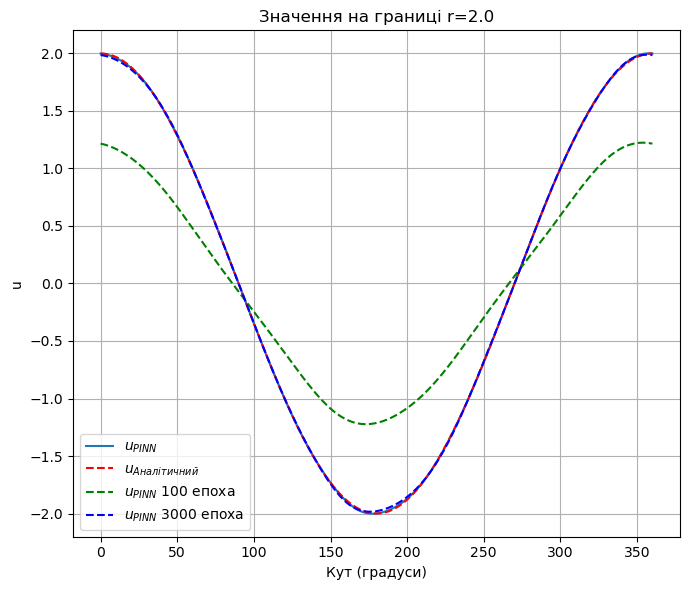

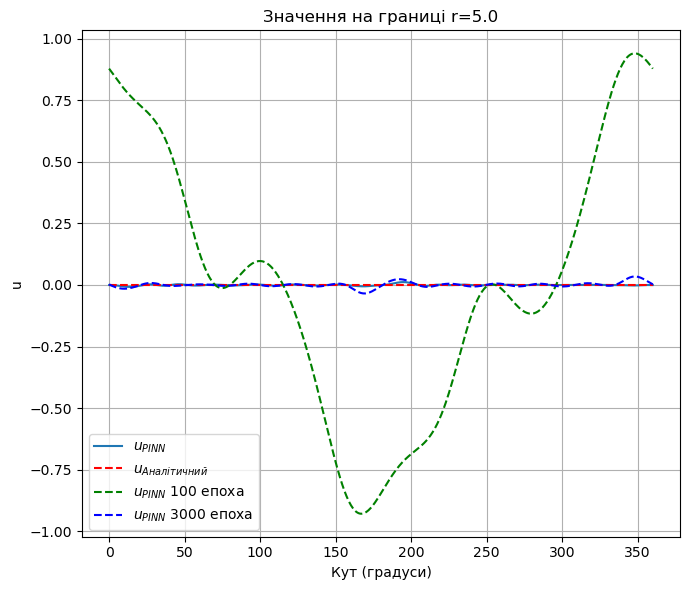

In [100]:

plotBoundary(inner_radius, inner_radius, bc1, N_of_test_points_2D, model_2D)
plotBoundary(outer_radius, outer_radius, bc2, N_of_test_points_2D, model_2D)

In [72]:
def calculate_max_relative_error(u_pred, u_exact):
    u_pred_flat = u_pred.flatten()
    u_exact_flat = u_exact.flatten()
    return 100 * np.linalg.norm(u_exact_flat - u_pred_flat, np.inf) / np.linalg.norm(u_exact_flat, np.inf)

In [73]:
def relative_l2_norm_error(u_pred, u_true):
    u_pred_flat = u_pred.flatten()
    u_exact_flat = u_true.flatten()
    error_norm = np.linalg.norm(u_exact_flat - u_pred_flat)
    true_norm = np.linalg.norm(u_exact_flat)
    return 100 * error_norm / true_norm

In [76]:
def compute_errors(u_pinn_values, u_fem_values):
    mse_error = np.mean((u_fem_values - u_pinn_values)**2)
    print(f"Mean Squared Error (PINN and FEM): {mse_error:.3}")
    relative_error = calculate_max_relative_error(u_fem_values, u_pinn_values)
    display(Latex(f"Relative $l^{{\\infty}}$ error (PINN and FEM): {relative_error:.3}%"))
    relative_l2_error = relative_l2_norm_error(u_fem_values, u_pinn_values)
    display(Latex(f"Relative $l^{2}$ error (PINN and FEM): {relative_l2_error:.3}%"))


In [90]:
compute_errors(u_pinn_values, u_fem_values)

Mean Squared Error (PINN and FEM): 0.613


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [91]:
compute_errors(u_pinn_values_3000, u_fem_values)

Mean Squared Error (PINN and FEM): 0.666


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [92]:
compute_errors(u_pinn_values_100, u_fem_values)

Mean Squared Error (PINN and FEM): 0.75


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [101]:
def getBoundaryValues_(r, r_fem, bc_exact_fn, N, model_2D):
    angles = np.linspace(0, 2 * np.pi, N)
    x = r * np.cos(angles)
    y = r * np.sin(angles)
    xy_test = np.column_stack([x, y])

    u_pinn_bc = model_2D.model(xy_test).numpy()
    u_pinn_values_100_bc = model_2D_100(xy_test).numpy()
    u_pinn_values_3000_bc = model_2D_3000(xy_test).numpy()
    u_fem_bc = np.array([u_fem(u_fem_values[i], u_fem_values[i]) for i in range(N_of_test_points_2D)])
    u_exact_bc = bc_exact_fn(xy_test[:,0], xy_test[:,1])
    

    return np.degrees(angles), u_pinn_bc, u_exact_bc, u_pinn_values_100_bc, u_pinn_values_3000_bc, u_fem_bc

In [ ]:
# angles_inner, u_pinn_bc_inner, u_fem_bc_inner, _, _, u_fem_bc_inner = getBoundaryValues_(inner_radius, inner_radius, bc1, 8, model_2D)
# angles_outer, u_pinn_bc_outer, u_fem_bc_outer, _, _, u_fem_bc_outer = getBoundaryValues_(outer_radius, outer_radius-1, bc2, 8, model_2D)

# u_pinn_bc = model_2D.model(xy_test).numpy()
# u_fem_bc = np.array([u_fem(x_fem[i], y_fem[i]) for i in range(N_of_test_points_2D)])
# u_exact_bc = bc_exact_fn(xy_test[:,0], xy_test[:,1])

In [ ]:
# data_left = {
#     "Кут (градуси)": np.linspace(L_t, R_t, N_of_time_steps)[indices_t],
#     "МСЕ": left_boundary_fem_values_10[indices_t],
#     "PINN": left_boundary_pinn_values[indices_t]
# }

# df_left = pd.DataFrame(data_left).round(3)
# print(f"Values on left boundary (x={x_positions[left_index]}):")
# print(df_left)


# data_right = {
#     "Кут (градуси)": np.linspace(L_t, R_t, N_of_time_steps)[indices_t],
#     "МСЕ": right_boundary_fem_values_10[indices_t],
#     "PINN": right_boundary_pinn_values[indices_t]
# }

# df_right = pd.DataFrame(data_right).round(3)
# print(f"Values on right boundary (x={x_positions[right_index]}):")
# print(df_right)